# Source and Sink contributions

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import netCDF4 as nc
import seaborn as sns; sns.set()
import warnings
from calendar import monthrange
warnings.filterwarnings("ignore")

%matplotlib inline

#### Parameters:

In [2]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax-imin
jsize = jmax-jmin

# model results:
results_folder = '/data/brogalla/run_storage/Mn-reference-202204/'
month = 8

# colours:
land_color = "#a9a7a2"
colors = ['#ccb598', '#367073', '#81a885', '#CC8741', '#cee7fd', '#c7cdd2', '#86DD8E']

#### Load files:

In [3]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base   = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base   = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t        = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)
e1t        = np.tile(e1t_base, (50,1,1))
e2t        = np.tile(e2t_base, (50,1,1))
volume     = e1t*e2t*e3t
area_base  = e1t_base*e2t_base
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask[0,:,:] < 0.1), area_base)
nav_lev       = np.array(mask.variables['nav_lev'])
hdept      = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]
mbathy     = np.array(mask.variables['mbathy'])[0,imin:imax,jmin:jmax]

lons  = np.array(mask.variables['nav_lon'])[imin:imax,jmin:jmax]
lats  = np.array(mask.variables['nav_lat'])[imin:imax,jmin:jmax]
depth = np.array(mask.variables['hdept'])[:,imin:imax,jmin:jmax]

In [4]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#### Functions:

In [5]:
def load_results(folder_ref, year, exp='ref'):
    
    months     = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv    = np.empty((12,isize,jsize))   ; dmn_sed = np.empty((12,isize,jsize)); 
    dmn_atm    = np.empty((12,isize,jsize))   ; dmn_ice = np.empty((12,isize,jsize));
    dmn_sedice = np.empty((12,isize,jsize))   ; dmn_priv= np.empty((12,isize,jsize));
    dmn_red    = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize)); 
    dmn_bio    = np.empty((12,50,isize,jsize));
    
    for i, month in enumerate(months):
        file        = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month}-{year}{month}.nc'
        ref_monthly = nc.Dataset(f'{folder_ref}{file}')
        
        dmn_riv[i,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]
        if exp=='spm':
            dmn_priv[i,:,:] = np.array(ref_monthly.variables['pmnriv'])[0,:,:]
            dmn_bio[i,:,:]  = 0
        elif exp=='bio':
            dmn_priv[i,:,:] = 0
            dmn_bio[i,:,:]  = np.array(ref_monthly.variables['dmnbio'])[0,:,:,:]
        else:
            dmn_priv[i,:,:] = 0
            dmn_bio[i,:,:]  = 0
        dmn_sed[i,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]
        dmn_sedice[i,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]
        dmn_atm[i,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_mpriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_priv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)
    dmn_mbio    = np.ma.masked_where((tmask_full < 0.1), dmn_bio)

    return dmn_mriv, dmn_priv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi, dmn_mbio

In [6]:
def plot_year_importance(fig, ax, proj1):
    
    x, y = proj1(lons, lats)
    
    axes=[ax[0,0], ax[0,1], ax[0,2], ax[0,3], \
          ax[1,0], ax[1,1], ax[1,2], ax[1,3], \
          ax[2,0], ax[2,1], ax[2,2], ax[2,3]]
    
    for month in range(0,12):
        riv_imp, sed_imp, sice_imp, red_imp, ice_imp, atm_imp = comp_importance(month, spatial)
        
        sz = 0.1
    
        proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'p', markersize=sz,c=colors[0], ax=axes[month]  , zorder=2)
        proj1.plot(x[~red_imp.mask], y[~red_imp.mask],'p', markersize=sz, c=colors[2], ax=axes[month] , zorder=2)
        proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'p', markersize=sz, c=colors[3], ax=axes[month] , zorder=2)
        proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'p', markersize=sz, c=colors[4], ax=axes[month] , zorder=2)
        proj1.plot(x[~sice_imp.mask], y[~sice_imp.mask],'p', markersize=sz, c=colors[5], ax=axes[month],zorder=2)
        proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'p', markersize=sz, c=colors[1], ax=axes[month] , zorder=2)
        proj1.plot(x[~bio_imp.mask], y[~bio_imp.mask],'p', markersize=sz, c=colors[6], ax=axes[month] , zorder=2)
        
        proj1.plot(x[-1,300:-1], y[-1,300:-1], '-w', linewidth=3, ax=axes[month])
        proj1.plot(x[0,360:500], y[0,360:500], '-w', linewidth=3, ax=axes[month])
        proj1.plot(x[150:-1,-1], y[150:-1,-1], '-w', linewidth=3, ax=axes[month])
        
        proj1.contourf(x, y, land_mask[0,:,:], vmax=0.3, ax=axes[month], \
                       cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)
        
        axes[month].set_title(months[month])
    
    return

In [7]:
def comp_importance(month, spatial, output=False): 
    
    riv_prop    = spatial[0,:,:,:]
    sed_prop    = spatial[1,:,:,:]
    sedice_prop = spatial[2,:,:,:]
    ice_prop    = spatial[3,:,:,:]
    atm_prop    = spatial[4,:,:,:]
    bio_prop    = spatial[5,:,:,:]
    red_prop    = spatial[6,:,:,:]
    oxi_prop    = spatial[7,:,:,:]
    scav_prop   = red_prop - oxi_prop
                                                 
    # Rivers
    riv_imp = np.ma.masked_where((riv_prop[month,:,:] < sed_prop[month,:,:]), riv_prop[month,:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < sedice_prop[month,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < atm_prop[month,:,:])   , riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < ice_prop[month,:,:])   , riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < scav_prop[month,:,:])  , riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < bio_prop[month,:,:])   , riv_imp[:,:])

    # Sediment release from ice
    sice_imp = np.ma.masked_where((sedice_prop[month,:,:] < riv_prop[month,:,:]), sedice_prop[month,:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < sed_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < atm_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < ice_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < scav_prop[month,:,:]), sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < bio_prop[month,:,:]) , sice_imp[:,:])
    
    # Sediment resuspension
    sed_imp = np.ma.masked_where((sed_prop[month,:,:] < riv_prop[month,:,:]), sed_prop[month,:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < sedice_prop[month,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < atm_prop[month,:,:])   , sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < ice_prop[month,:,:])   , sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < scav_prop[month,:,:])  , sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < bio_prop[month,:,:])   , sed_imp[:,:])

    # Reduction
    scav_imp = np.ma.masked_where((scav_prop[month,:,:] < sed_prop[month,:,:]), scav_prop[month,:,:])
    scav_imp = np.ma.masked_where((scav_imp[:,:]  < sedice_prop[month,:,:]), scav_imp[:,:])
    scav_imp = np.ma.masked_where((scav_imp[:,:]  < atm_prop[month,:,:])   , scav_imp[:,:])
    scav_imp = np.ma.masked_where((scav_imp[:,:]  < ice_prop[month,:,:])   , scav_imp[:,:])
    scav_imp = np.ma.masked_where((scav_imp[:,:]  < riv_prop[month,:,:])   , scav_imp[:,:])
    scav_imp = np.ma.masked_where((scav_imp[:,:]  < bio_prop[month,:,:])   , scav_imp[:,:])

    # Dust from ice
    ice_imp = np.ma.masked_where((ice_prop[month,:,:] < sed_prop[month,:,:]), ice_prop[month,:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < sedice_prop[month,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < atm_prop[month,:,:])   , ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < riv_prop[month,:,:])   , ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < scav_prop[month,:,:])  , ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < bio_prop[month,:,:])   , ice_imp[:,:])

    # Dust directly from atmosphere
    atm_imp = np.ma.masked_where((atm_prop[month,:,:] < sed_prop[month,:,:]), atm_prop[month,:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < sedice_prop[month,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < riv_prop[month,:,:])   , atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < ice_prop[month,:,:])   , atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < scav_prop[month,:,:])  , atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < bio_prop[month,:,:])   , atm_imp[:,:])
    
    # Uptake and remineralization
    bio_imp = np.ma.masked_where((bio_prop[month,:,:] < sed_prop[month,:,:]), bio_prop[month,:,:])
    bio_imp = np.ma.masked_where((bio_imp[:,:]  < sedice_prop[month,:,:]), bio_imp[:,:])
    bio_imp = np.ma.masked_where((bio_imp[:,:]  < atm_prop[month,:,:])   , bio_imp[:,:])
    bio_imp = np.ma.masked_where((bio_imp[:,:]  < ice_prop[month,:,:])   , bio_imp[:,:])
    bio_imp = np.ma.masked_where((bio_imp[:,:]  < riv_prop[month,:,:])   , bio_imp[:,:])
    bio_imp = np.ma.masked_where((bio_imp[:,:]  < scav_prop[month,:,:])  , bio_imp[:,:])
    
    # Mask all places where the maximum contribution is very small:
    threshold = 5e-7 #5e-8
    riv_imp  = np.ma.masked_where((riv_imp[:,:]  < threshold), riv_imp[:,:] )
    sice_imp = np.ma.masked_where((sice_imp[:,:] < threshold), sice_imp[:,:])
    sed_imp  = np.ma.masked_where((sed_imp[:,:]  < threshold), sed_imp[:,:] )
    scav_imp = np.ma.masked_where((scav_imp[:,:] < threshold), scav_imp[:,:] )
    ice_imp  = np.ma.masked_where((ice_imp[:,:]  < threshold), ice_imp[:,:] )
    atm_imp  = np.ma.masked_where((atm_imp[:,:]  < threshold), atm_imp[:,:] )
    bio_imp  = np.ma.masked_where((bio_imp[:,:]  < threshold), bio_imp[:,:] )

    if output:
        print('Rivers       --- Masked values before: ', np.ma.count_masked(riv_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(riv_imp[:,:]))
        print('Rivers       --- Non-masked values:    ', np.ma.count(riv_imp[:,:]))
        print('Sediment     --- Masked values before: ', np.ma.count_masked(sed_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(sed_imp[:,:]))
        print('Sediment     --- Non-masked values:    ', np.ma.count(sed_imp[:,:]))
        print('Sediment ice --- Masked values before: ', np.ma.count_masked(sedice_prop[month,:,:]), ', after: ', \
        np.ma.count_masked(sice_imp[:,:]))
        print('Sediment ice --- Non-masked values:    ', np.ma.count(sice_imp[:,:]))
        print('Reduction    --- Masked values before: ', np.ma.count_masked(scav_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(scav_imp[:,:]))
        print('Reduction    --- Non-masked values:    ', np.ma.count(scav_imp[:,:]))
        print('Dust ice     --- Masked values before: ', np.ma.count_masked(ice_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(ice_imp[:,:]))
        print('Dust ice     --- Non-masked values:    ', np.ma.count(ice_imp[:,:]))
        print('Dust direct  --- Masked values before: ', np.ma.count_masked(atm_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(atm_imp[:,:]))
        print('Dust direct  --- Non-masked values:    ', np.ma.count(atm_imp[:,:]))
        print('Uptake and remin --- Masked values before: ', np.ma.count_masked(bio_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(bio_imp[:,:]))
        print('Uptake and remin  --- Non-masked values:    ', np.ma.count(bio_imp[:,:]))

    return riv_imp, sed_imp, sice_imp, scav_imp, ice_imp, atm_imp, bio_imp

In [12]:
def calculate_contribution(year, output=False, exp='ref'): 
    
    # Calculate the contribution of the model components:    
    folder_year = f'ANHA12_ref-{year}_20220422/'
    dmn_mriv, dmn_mpriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred, dmn_moxi, dmn_mbio = \
                    load_results(results_folder+folder_year, year, exp=exp)
    
    #### moles per second
    # Sum particulate and dissolved contributions to river dissolved Mn 
    riv    = (dmn_mriv   * volume_masked[0,:,:] * 1e3) + (dmn_mpriv * volume_masked[0,:,:] * 1e3)
    sed    = dmn_msed    * volume_bottom        * 1e3
    sedice = dmn_msedice * volume_masked[0,:,:] * 1e3
    atm    = dmn_matm    * volume_masked[0,:,:] * 1e3
    ice    = dmn_mice    * volume_masked[0,:,:] * 1e3
    # 3D fields only calculated over full water column:
    bio    = dmn_mbio[:,:,:,:] * volume_masked[:,:,:] * 1e3
    red    = dmn_mred[:,:,:,:] * volume_masked[:,:,:] * 1e3
    oxi    = dmn_moxi[:,:,:,:] * volume_masked[:,:,:] * 1e3
    
    #### moles per meter squared per second as a 2D field
    rivm2    = (dmn_mriv   * e3t_masked[0,:,:] * 1e3) + (dmn_mpriv * e3t_masked[0,:,:] * 1e3)
    sedm2    = dmn_msed    * e3t_bottom * 1e3
    sedicem2 = dmn_msedice * e3t_masked[0,:,:] * 1e3
    atmm2    = dmn_matm    * e3t_masked[0,:,:] * 1e3
    icem2    = dmn_mice    * e3t_masked[0,:,:] * 1e3
    # 3D fields calculated over full water column:
    biom2    = np.ma.sum(dmn_mbio[:,:,:,:] * e3t_masked[:,:,:],axis=1) * 1e3 / hdept[:,:]
    redm2    = np.ma.sum(dmn_mred[:,:,:,:] * e3t_masked[:,:,:],axis=1) * 1e3 / hdept[:,:]
    oxim2    = np.ma.sum(dmn_moxi[:,:,:,:] * e3t_masked[:,:,:],axis=1) * 1e3 / hdept[:,:]
    
    #### Total monthly contribution to domain: (moles per month)
    days_in_months = np.array([monthrange(year, month)[1] for month in range(1,13)]) # vector of number of days in month
    days_in_months[days_in_months == 29] = 28 # no leap years
    atm_mnth    = np.ma.sum(atm[:,:,:]   , axis=(1,2))  *3600*24*days_in_months
    riv_mnth    = np.ma.sum(riv[:,:,:]   , axis=(1,2))  *3600*24*days_in_months
    sed_mnth    = np.ma.sum(sed[:,:,:]   , axis=(1,2))  *3600*24*days_in_months
    sedice_mnth = np.ma.sum(sedice[:,:,:], axis=(1,2))  *3600*24*days_in_months
    ice_mnth    = np.ma.sum(ice[:,:,:]   , axis=(1,2))  *3600*24*days_in_months    
    # Average contribution over full water column
#     bio_mnth    = np.ma.sum(bio[:,:,:,:], axis=(1,2,3))*3600*24*days_in_months
#     red_mnth    = np.ma.sum(red[:,:,:,:], axis=(1,2,3))*3600*24*days_in_months
#     oxi_mnth    = np.ma.sum(oxi[:,:,:,:], axis=(1,2,3))*3600*24*days_in_months
    bio_mnth    = np.ma.sum((np.ma.sum(bio[:,:,:,:], axis=1)/hdept[:,:]),axis=(1,2))*3600*24*days_in_months
    red_mnth    = np.ma.sum((np.ma.sum(red[:,:,:,:], axis=1)/hdept[:,:]),axis=(1,2))*3600*24*days_in_months
    oxi_mnth    = np.ma.sum((np.ma.sum(oxi[:,:,:,:], axis=1)/hdept[:,:]),axis=(1,2))*3600*24*days_in_months
    
    #### Average monthly contribution over domain: (moles per meter squared per month)
    total_area    = np.ma.sum(area_masked[:,:])
    atmm2_mnth    = atm_mnth    / total_area
    rivm2_mnth    = riv_mnth    / total_area
    sedm2_mnth    = sed_mnth    / total_area
    sedicem2_mnth = sedice_mnth / total_area    
    icem2_mnth    = ice_mnth    / total_area
    biom2_mnth    = bio_mnth    / total_area ## Note that these are an average over the water column
    redm2_mnth    = red_mnth    / total_area ##
    oxim2_mnth    = oxi_mnth    / total_area ##

    total_monthly_contribution = np.array([riv_mnth, sed_mnth, sedice_mnth, ice_mnth, atm_mnth, \
                                          bio_mnth, red_mnth, oxi_mnth])           # mol/yr
    ave_monthly_contribution   = np.array([rivm2_mnth, sedm2_mnth, sedicem2_mnth, icem2_mnth, \
                                          atmm2_mnth, biom2_mnth, redm2_mnth, oxim2_mnth]) # mol/m2/yr
    
    monthly_contribution = np.vstack((np.array([rivm2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24, \
                                      np.array([sedm2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24, \
                                      np.array([sedicem2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24, \
                                      np.array([icem2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24, \
                                      np.array([atmm2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24, \
                                      np.array([biom2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24, \
                                      np.array([redm2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24, \
                                      np.array([oxim2[i,:,:]*days_in_months[i] for i in range(0,12)])*3600*24))
    monthly_contribution = monthly_contribution.reshape(8, 12, isize, jsize)
    
    return total_monthly_contribution, ave_monthly_contribution, monthly_contribution

#### Calculations:

Calculate the moles of Mn contributed to each grid cell

In [9]:
tmask_bot = np.copy(tmask)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))

In [10]:
e3t_bot = np.zeros((isize,jsize))
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            e3t_bot[i,j] = e3t[k,i,j]
            vol_bot[i,j] = volume[k,i,j]
        except:
            e3t_bot[i,j] = np.nan
            vol_bot[i,j] = np.nan
        
e3t_bottom    = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(e3t_bot), e3t_bot))
volume_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(vol_bot), vol_bot))

In [13]:
total_2002, ave_2002, spatial_2002 = calculate_contribution(2002, output=False, exp='ref')
total_2003, ave_2003, spatial_2003 = calculate_contribution(2003, output=False, exp='ref')
total_2004, ave_2004, spatial_2004 = calculate_contribution(2004, output=False, exp='ref')
total_2005, ave_2005, spatial_2005 = calculate_contribution(2005, output=False, exp='ref')
total_2006, ave_2006, spatial_2006 = calculate_contribution(2006, output=False, exp='ref')
total_2007, ave_2007, spatial_2007 = calculate_contribution(2007, output=False, exp='ref')
total_2008, ave_2008, spatial_2008 = calculate_contribution(2008, output=False, exp='ref')
total_2009, ave_2009, spatial_2009 = calculate_contribution(2009, output=False, exp='ref')
total_2010, ave_2010, spatial_2010 = calculate_contribution(2010, output=False, exp='ref')
total_2011, ave_2011, spatial_2011 = calculate_contribution(2011, output=False, exp='ref')
total_2012, ave_2012, spatial_2012 = calculate_contribution(2012, output=False, exp='ref')
total_2013, ave_2013, spatial_2013 = calculate_contribution(2013, output=False, exp='ref')
total_2014, ave_2014, spatial_2014 = calculate_contribution(2014, output=False, exp='ref')
total_2015, ave_2015, spatial_2015 = calculate_contribution(2015, output=False, exp='ref')
total_2016, ave_2016, spatial_2016 = calculate_contribution(2016, output=False, exp='ref')
total_2017, ave_2017, spatial_2017 = calculate_contribution(2017, output=False, exp='ref')
total_2018, ave_2018, spatial_2018 = calculate_contribution(2018, output=False, exp='ref')
total_2019, ave_2019, spatial_2019 = calculate_contribution(2019, output=False, exp='ref')

In [14]:
spatial = np.vstack((spatial_2002, spatial_2003, spatial_2004, spatial_2005, spatial_2006, spatial_2007, \
                     spatial_2008, spatial_2009, spatial_2010, spatial_2011, spatial_2012, \
                     spatial_2013, spatial_2014, spatial_2015, spatial_2016, spatial_2017, \
                     spatial_2018, spatial_2019))
spatial_years = spatial.reshape(18,8,12,700,640)

In [15]:
spatial_average = np.mean(spatial_years, axis=0)

In [16]:
average = np.vstack((ave_2002, ave_2003, ave_2004, ave_2005, ave_2006, ave_2007, ave_2008, ave_2009, \
                     ave_2010, ave_2011, ave_2012, ave_2013, ave_2014, ave_2015, ave_2016, \
                     ave_2017, ave_2018, ave_2019))
average_years = np.mean(average.reshape(18,8,12),axis=0)*1e6 # Calculate the average over 18 year time series and convert to micromol

In [17]:
total = np.vstack((total_2002, total_2003, total_2004, total_2005, total_2006, total_2007, total_2008, total_2009, \
                   total_2010, total_2011, total_2012, total_2013, total_2014, total_2015, total_2016, \
                   total_2017, total_2018, total_2019))
total_years = np.mean(total.reshape(18,8,12),axis=0)*1e6

##### Bar plot of monthly components

- consider either: averaging scavenging over the full water column OR sediment resuspension into the PML, not both.

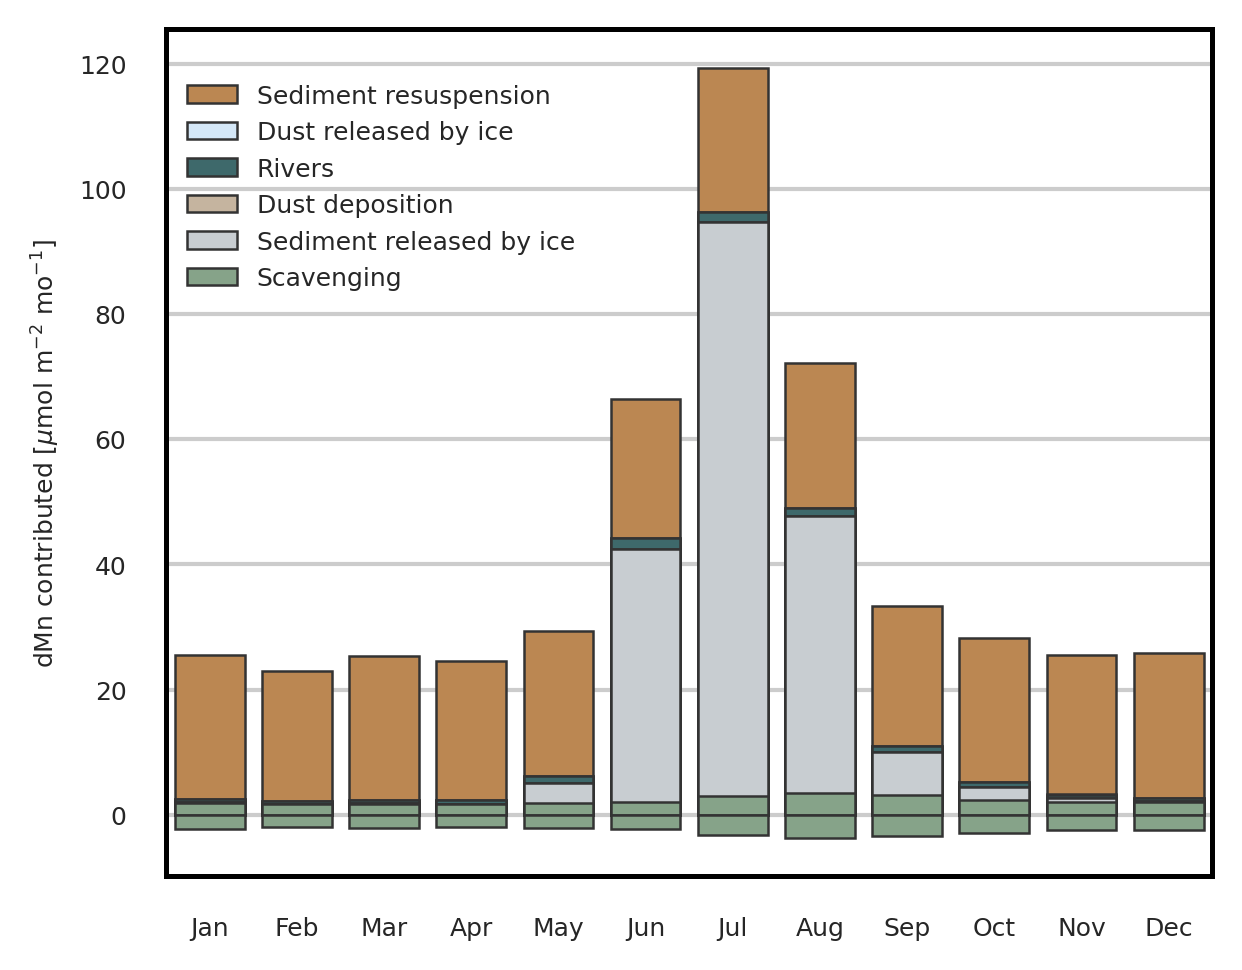

In [19]:
fig = plt.figure(figsize=(4.5, 3.74), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
#     # uptake and remineralization:
#     icr= sns.barplot(months, average_years[6,:] + average_years[5,:] + average_years[2,:] + average_years[4,:] + \
#                      average_years[0,:] + average_years[3,:] + average_years[1,:],\
#                      color=colors[6], edgecolor=".2", label='Uptake and remineralization')
    # sediment:
    icp= sns.barplot(months, average_years[6,:] + average_years[2,:] + average_years[4,:] + \
                     average_years[0,:] + average_years[3,:] + average_years[1,:],\
                     color=colors[3], edgecolor=".2", label='Sediment resuspension')
    # ice:
    rip= sns.barplot(months, average_years[6,:] + average_years[2,:] + average_years[4,:] + \
                     average_years[0,:] + average_years[3,:], \
                     color=colors[4], edgecolor=".2", label='Dust released by ice')
    # rivers:
    sep= sns.barplot(months, average_years[6,:] + average_years[2,:] + average_years[4,:] + average_years[0,:], \
                     color=colors[1], edgecolor=".2", label='Rivers')
    # dust:
    dup= sns.barplot(months, average_years[6,:] + average_years[2,:] + average_years[4,:], \
                     color=colors[0], edgecolor=".2", label='Dust deposition')
    
    # sediment in ice:
    icp= sns.barplot(months, average_years[6,:] + average_years[2,:], \
                     color=colors[5], edgecolor=".2", label='Sediment released by ice') 

    # Scavenging:
    scp= sns.barplot(months, average_years[6,:], color=colors[2], edgecolor=".2", label='Scavenging') 
    scn= sns.barplot(months, -average_years[7,:], color=colors[2], edgecolor=".2") 
    
    plt.setp(icp.patches, linewidth=0.6)
    
    icp.set_ylabel(r'dMn contributed [$\mu$mol m$^{-2}$ mo$^{-1}$]', fontsize=6)
    icp.tick_params(axis='both', which='major', labelsize=6)
    icp.spines['left'].set_linewidth(1.2);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.2); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.2);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.2);    icp.spines['top'].set_color('black');    
    
    icp.legend(loc=(0.01, 0.68), fontsize=6, frameon=False)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R4a-budget.jpg', \
               bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R4a-budget.svg', \
               bbox_inches='tight', dpi=300, format='svg')

##### Figure of spatial variation in component importance:

Sum the contribution of each model component over the course of a year

In [20]:
riv_imp, sed_imp, sedice_imp, red_imp, ice_imp, atm_imp, bio_imp = comp_importance(8, spatial_average, output=True)
# riv_imp, sed_imp, sedice_imp, red_imp, ice_imp, atm_imp = comp_importance(8, spatial_2015, output=True)

Rivers       --- Masked values before:  0 , after:  447060
Rivers       --- Non-masked values:     940
Sediment     --- Masked values before:  0 , after:  350543
Sediment     --- Non-masked values:     97457
Sediment ice --- Masked values before:  0 , after:  310985
Sediment ice --- Non-masked values:     137015
Reduction    --- Masked values before:  0 , after:  447904
Reduction    --- Non-masked values:     96
Dust ice     --- Masked values before:  0 , after:  448000
Dust ice     --- Non-masked values:     0
Dust direct  --- Masked values before:  0 , after:  448000
Dust direct  --- Non-masked values:     0
Uptake and remin --- Masked values before:  0 , after:  448000
Uptake and remin  --- Non-masked values:     0


In [22]:
ice_imp = np.ma.masked_where((tmask[0,:,:] < 0.1), ice_imp)

Only include contributions above 0.2 nM:

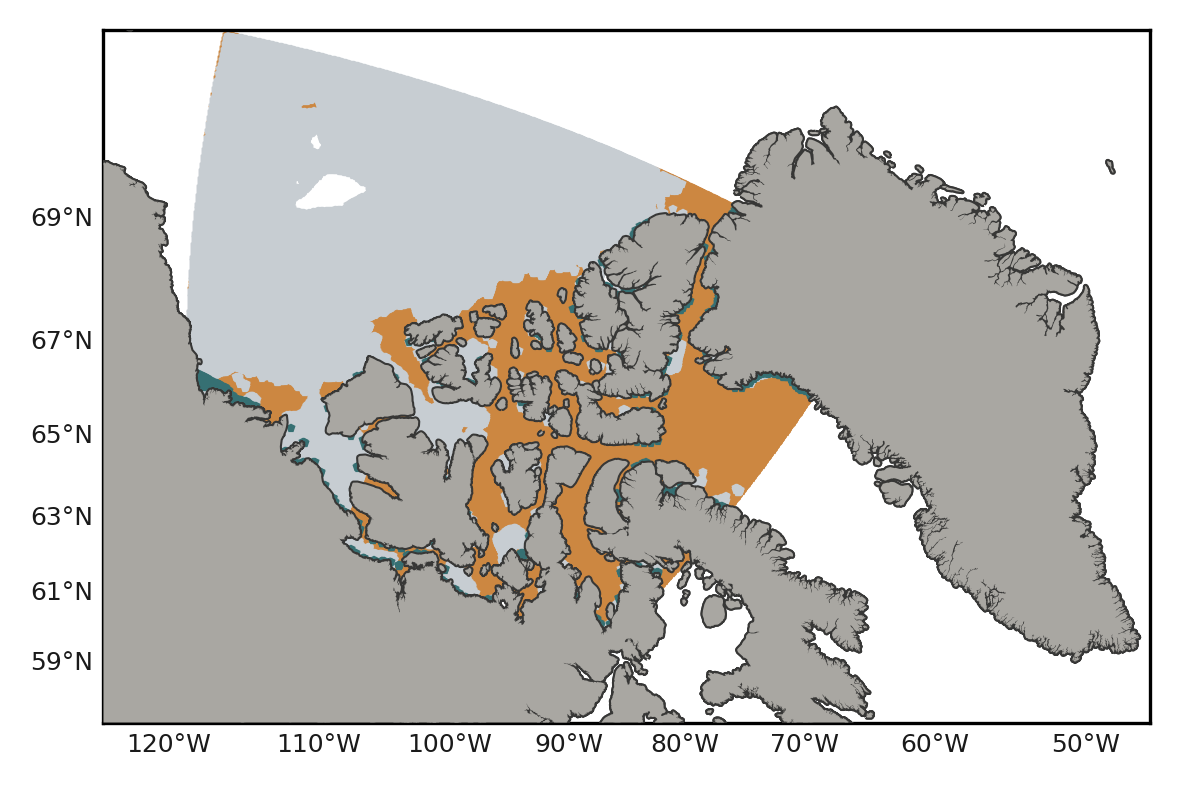

In [26]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x, y = proj1(lons, lats)
    
sz = 1.2
land_color         = '#a9a7a2'
land_outline_color = '#373736'
    
proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'p'  , markersize=sz, c=colors[0], zorder=2)
proj1.plot(x[~red_imp.mask], y[~red_imp.mask],'p'  , markersize=sz, c=colors[2], zorder=2)
proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'p'  , markersize=sz, c=colors[3], zorder=2)
proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'p'  , markersize=sz, c=colors[4], zorder=2)
proj1.plot(x[~sedice_imp.mask], y[~sedice_imp.mask],'p', markersize=sz, c=colors[5], zorder=2)
proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'p'  , markersize=sz, c=colors[1], zorder=2)
proj1.plot(x[~bio_imp.mask], y[~bio_imp.mask],'p'  , markersize=sz, c=colors[6], zorder=2)

proj1.drawcoastlines(color=land_outline_color, linewidth=1.0, zorder=5)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=6);
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R4b-budget.jpg', \
               bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R4b-budget.svg', \
               bbox_inches='tight', dpi=300, format='svg')